In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [2]:
# Single subagent, ssh comm method, manually increased processes PRRTE
exp4_sessions = pd.read_csv('../data/exp4/sessions.csv', index_col=0)
exp4_pilots = pd.read_csv('../data/exp4/pilots.csv', index_col=0)
exp4_units = pd.read_csv('../data/exp4/units.csv', index_col=0)

# Single subagent, ssh comm method, manually increased processes PRRTE
exp4_prrte_sessions = pd.read_csv('../data/exp4/sessions_prte.csv', index_col=0)
exp4_prrte_units = pd.read_csv('../data/exp4/units_prte.csv', index_col=0)

# Plot task overhead for task execution communication
exp4_prrte_phase2 = pd.read_csv('../data/exp4/prrte_phase2.csv')

In [3]:
print 'Experiment 4: Baseline: Total number of successful runs: %s' % exp4_sessions.shape[0]
print 'Experiment 4: Baseline: Total number of pilots: %s' % exp4_pilots.shape[0]
print 'Experiment 4: Baseline: Total number of units: %s\n' % exp4_units.shape[0]

Experiment 4: Baseline: Total number of successful runs: 11
Experiment 4: Baseline: Total number of pilots: 11
Experiment 4: Baseline: Total number of units: 65536



In [4]:
exp4_sessions.loc[exp4_sessions.ncore == 84, 'ncore'] = 168
exp4_sessions['nnode'] = exp4_sessions.ncore/168
exp4_sessions['nnode'] = exp4_sessions['nnode'].apply(np.ceil)
exp4_sessions['list'] = exp4_sessions[['nunit','nnode']].astype(int, errors='ignore').astype('str').values.tolist()
exp4_sessions['nunitnode'] = exp4_sessions['list'].apply('/'.join)

exp4_ws = exp4_sessions[
    ['nunit','nunitnode','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING',
     'U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING',
     'cu_exec_start_stop','nunit_failed','util_p_total']].groupby(['nunit','nunitnode']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'cu_exec_start_stop'  : ['mean','std'],
                 'util_p_total'        : ['mean','std'],
                 'nunit_failed'        : ['mean']
                })

exp4_ws.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
exp4_ws.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
exp4_ws.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
exp4_ws.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
exp4_ws.rename({'U_AGENT_EXECUTING'   :'TTX Agent'}, axis='columns', inplace=True)
exp4_ws.rename({'cu_exec_start_stop'  :'TTX Unit'}, axis='columns', inplace=True)
exp4_ws.rename({'util_p_total'        :'TTX'}, axis='columns', inplace=True)

exp4_ws = exp4_ws.sort_values("nunit")
exp4_ws

TTQ              nunit_failed          TTX                       TTC                Agent scheduling               TTX Unit            Agent queueing           Agent queueing execution               TTX Agent           
                        mean          std         mean         mean         std          mean            std             mean       std         mean        std           mean       std                     mean        std         mean        std
nunit nunitnode                                                                                                                                                                                                                                     
1024  1024/26      62.138335     2.044089            0  1262.774100  228.521638  1.565891e+09    1197.888502         3.525402  1.112794  1029.523494  12.450692       6.074605  3.846145               129.496681  12.371917  1029.799317  12.386044
2048  2048/51    3321.691144  1797.622708            0  1290.376667   35.849751  1.566122e+09  201015.599012         6.917727  0.053415  1177.496137   1.836337       8.171157  0.105839               277.404578   1.828776  1177.697757   1.834351
4096  4096/101   1107.280731   389.605431            0  1533.592650    3.323190  1.566283e+09   24858.873702        18.923690  0.015265  1453.791537   0.995575      21.416204  0.161790               553.672961   0.968872  1454.006711   1.004316
8192  8192/202   1073.793338  1410.478176            0  2096.037950    3.075844  1.565890e+09    1390.698726        58.958676  0.181679  2015.041753   0.903093      63.883618  0.104586              1114.864786   0.920683  2015.256482   0.889548
16384 16384/410  7640.860945  3835.525718            0  3235.952600    8.007843  1.566395e+09   20380.394312       205.294122  6.426163  3127.766465   7.847302     215.039598  6.690071              2227.418262   7.845788  3127.977219   7.847944

In [5]:
# sessions exp4
exp4_sids = sorted(['../data/exp4/'+s for s in exp4_sessions.drop_duplicates(['nunit']).index.unique().tolist()])
exp4_sobjs = ra.Experiment(exp4_sids, stype='radical.pilot')

session loaded
session loaded
session loaded
session loaded
session loaded


In [6]:
metrics_prte = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Execution', ['exec_queue', 'exec_prep']],
        ['Execution RP',      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Execution PRTE',    ['prte_phase_1', 'prte_phase_2', 'prte_phase_3']],
        ['Execution Cmd',     ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]


metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Execution', ['exec_queue', 'exec_prep']],
        ['Execution RP',      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Execution Cmd',     ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [7]:
# choose the metrics we want to use for resource utilization
metrics = metrics_prte

# get utilization information
provided, consumed, stats_abs, stats_rel = exp4_sobjs.utilization(metrics=metrics)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


using prte configuration

rp.session.login4.mturilli1.018122.0002 [8192]
    Pilot Startup       :    1530921.555     2.076%      ['boot', 'setup_1']
    Pilot Termination   :     291795.318     0.396%      ['term']
    Agent Nodes         :     365089.045     0.495%      ['agent']
    Warmup              :    1441263.976     1.954%      ['warm']
    Draining            :   18857575.795    25.570%      ['drain']
    Idle                :    4513689.011     6.120%      ['idle']
    Prepare Execution   :   17238705.488    23.375%      ['exec_queue', 'exec_prep']
    Execution RP        :      15313.789     0.021%      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']
    Execution PRTE      :       1268.996     0.002%      ['prte_phase_1', 'prte_phase_2', 'prte_phase_3']
    Execution Cmd       :   29491981.248    39.990%      ['exec_cmd']
    Unschedule          :        382.787     0.001%      ['unschedule']
    total               :   73747987.007   100.000%      

    total              

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


rp.session.login4.mturilli1.018129.0000 [16384]
    Pilot Startup       :    2928790.967     1.271%      ['boot', 'setup_1']
    Pilot Termination   :     590003.652     0.256%      ['term']
    Agent Nodes         :     562070.495     0.244%      ['agent']
    Warmup              :    7625545.011     3.309%      ['warm']
    Draining            :   75477458.464    32.752%      ['drain']
    Idle                :   17908159.129     7.771%      ['idle']
    Prepare Execution   :   66321071.815    28.779%      ['exec_queue', 'exec_prep']
    Execution RP        :      48750.315     0.021%      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']
    Execution PRTE      :        181.255     0.000%      ['prte_phase_1', 'prte_phase_2', 'prte_phase_3']
    Execution Cmd       :   58984583.805    25.596%      ['exec_cmd']
    Unschedule          :       2287.960     0.001%      ['unschedule']
    total               :  230448902.868   100.000%      

    total               :  230448902.868   100.0

In [8]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in exp4_sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

/Users/mturilli/Virtualenvs/summit_jsrun_prte/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


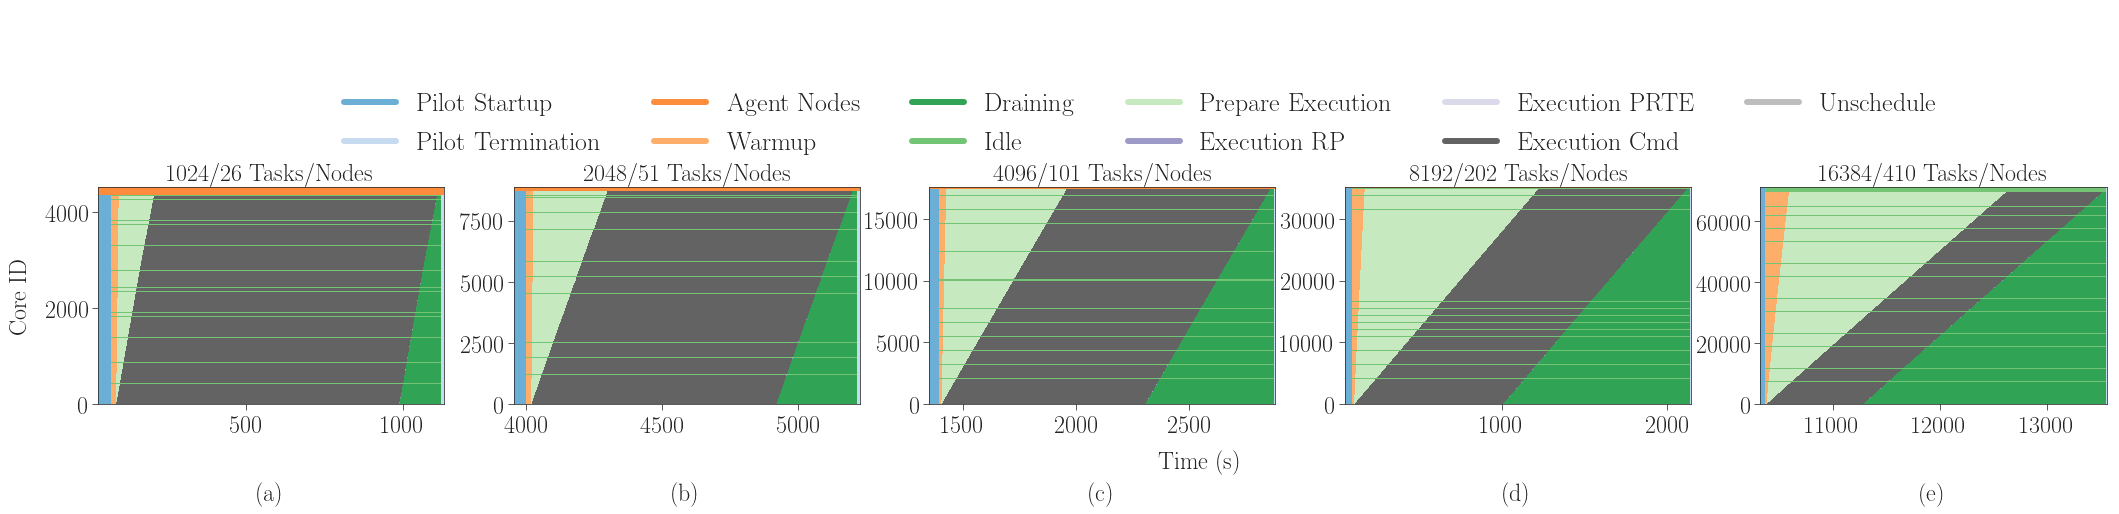

In [9]:
# core utilization over time (box plot)

sids = [ 'rp.session.login4.mturilli1.018119.0001', # 1024
         'rp.session.login4.mturilli1.018127.0001', # 2048
         'rp.session.login4.mturilli1.018128.0000', # 4096
         'rp.session.login4.mturilli1.018122.0002', # 8192
         'rp.session.login4.mturilli1.018129.0000'] # 16384

fwidth = 36
fhight = 4
fig, axarr = plt.subplots(1,
                          len(sids),
                          sharex='col',
                          figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in sids:

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (exp4_sessions.loc[sid].nunit, int(exp4_sessions.loc[sid].nnode)))

    for metric in metrics:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_min = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_min = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.09, 0.5, 'Core ID', va='center', rotation='vertical', fontsize=24)
fig.text(0.55, -0.1, 'Time (s)', ha='center', fontsize=24)
    
# Add legend
fig.legend(legend, 
           [m[0] for m in metrics], 
           loc='upper center', 
           bbox_to_anchor=(0.44, 1.55),
           fontsize=26,
           ncol=6)

plt.savefig('figures/paper_prrte_weak_scaling_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_prrte_weak_scaling_ru.png', dpi=300, bbox_inches='tight')